## Lab3 Part 2

Lab3 is splitted into two parts as it is gettign really long.
## Task 5.1 Dynamic Programming
The goal of this second half of the lab is to investigate dynamic progamming along scanlines in stereo vision.  In this part of the practical, we build a basic dynamic programming algorithm, which will solve the same problem as presented in the notes.  

In Task5 we will apply this to the stereo problem.  

Use the template below, filling in parts marked "TO DO" (only todo for Task 5.1 one is in functions.py).



In [27]:
import cv2
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
from functions import dynamicProgram
plt.close('all')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# define unary costs : unaryCosts[d,j] represents the cost for having
# disparity d at pixel j.
unaryCosts = np.array([[2.0, 1.1, 5.7, 1.5, 6.0, 3.1],
              [0.8, 4.8, 1.0, 3.0, 6.9, 3.3],
              [4.3, 2.3, 2.4, 2.4, 6.6, 6.2],
              [6.4, 0.0, 6.1, 0.8, 7.1, 2.1],
              [2.3, 2.2, 4.9, 8.9, 1.0, 9.8]])

# define pairwise costs:  pairwiseCosts[a,b] represents the cost for changing from 
# disparity level A at pixel j to disparity level B at pixel j+1;
pairwiseCosts = np.array([[   0,   2, 100, 100, 100],
                          [   2,   0,   2, 100, 100],
                          [ 100,   2,   0,   2, 100],
                          [ 100, 100,   2,   0,   2],
                          [ 100, 100, 100,   2,   0]])



In [29]:
# TODO Fill in the dynamicProgram function in "functions.py"

Processing position 1
    Path costs: [  3.1   3.9 105.4 107.5 103.4]
    Min cost = 3.1, Index = 0
Processing position 1
    Path costs: [  8.8   5.6  11.1 111.2 107.1]
    Min cost = 5.6, Index = 1
Processing position 1
    Path costs: [104.3   5.1   6.6  10.7 104.6]
    Min cost = 5.1, Index = 1
Processing position 1
    Path costs: [102.  100.8   6.3   6.4   4.3]
    Min cost = 4.3, Index = 4
Processing position 1
    Path costs: [104.2 103.  106.5  10.6   4.5]
    Min cost = 4.5, Index = 4
Processing position 2
    Path costs: [  8.8  13.3 110.8 110.  110.2]
    Min cost = 8.8, Index = 0
Processing position 2
    Path costs: [  6.1   6.6   8.1 105.3 105.5]
    Min cost = 6.1, Index = 0
Processing position 2
    Path costs: [105.5  10.    7.5   8.7 106.9]
    Min cost = 7.5, Index = 2
Processing position 2
    Path costs: [109.2 111.7  13.2  10.4  12.6]
    Min cost = 10.399999999999999, Index = 3
Processing position 2
    Path costs: [108.  110.5 110.   11.2   9.4]
    Min cost = 

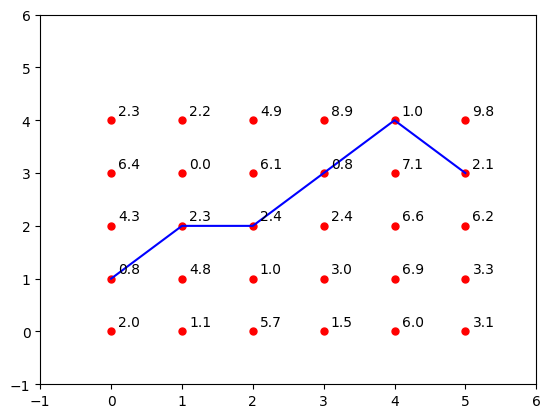

[[  0   2 100 100 100]
 [  2   0   2 100 100]
 [100   2   0   2 100]
 [100 100   2   0   2]
 [100 100 100   2   0]]


Pairwise Path Cost = 8
Unary Path Cost = 9.4
Path Cost = 17.4


In [35]:

# Now, use dynamic programming to find best solution.
bestPath = dynamicProgram(unaryCosts,pairwiseCosts)

# display the nodes
nY = len(unaryCosts)
nX = len(unaryCosts[0])
plt.axis([-1, 6, -1, 6])
for cY in range(nY):
    for cX in range(nX):
        plt.plot(cX,cY,'ro',ms=5.)
        plt.text(cX+.1, cY+.1, unaryCosts[cY,cX])


# display the best path
plt.plot(range(nX),bestPath,'b-')
plt.show()

# calculate the cost of the path computed
bestPathCostUnary = np.sum((np.transpose(unaryCosts).reshape((nX*nY,1)))[(np.add(nY * np.array(range(nX)),np.transpose(bestPath)[0])).astype(int)])

bestPathCostPairwise = np.sum(np.transpose(pairwiseCosts).reshape((nY*nY,1))[np.array([bestPath[0:-1]+nY*bestPath[1:]]).reshape((1,nY)).astype(int)[0]])

bestCost = bestPathCostUnary+bestPathCostPairwise
print(pairwiseCosts)
print('\n')
print('Pairwise Path Cost =',bestPathCostPairwise)
print('Unary Path Cost =',bestPathCostUnary)

print('Path Cost =',bestCost)

## Task 5.2 Dynamic Programming for stereo depth estimation


The goal of this part of the practical is to use the dynamic programming routine that you developed in the first part to solve the dense stero problem.

Use the template below, filling in parts marked "TO DO".

### Extra Tasks:
Task hint: Crop or downsample your image if your stereo is slow

Task1: Capture or find two image pairs: one with good stereo depth and one with bad stereo depth. Note that you should only the two camera have a known, and there should be no moving objects in the scene.

Task2: Measure your baseline distance between the camera with a ruler, does the depth esimation match the real distance？

Task3: (Unmarked Optional) Can you use two cameras at the same time for stereo capture?

In [7]:
%load_ext autoreload
%autoreload 2

import numpy as np 
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
from functions import dynamicProgram, dynamicProgramVec
plt.close('all')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# load in images and ground truth
data = loadmat('../dataset/StereoData.mat')
im1 = data['im1'].astype('int')
im2 = data['im2'].astype('int')
gt = data['gt'].astype('int')

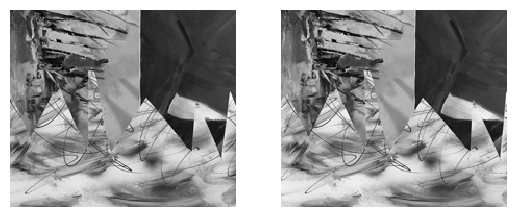

In [9]:
# ground truth disparity is originally expressed in 16'ths of pixels but we 
# will only consider whole-pixel shifts
gtDisp = np.round(gt.astype(float)/16)

im1show = im1
im2show = im2
if np.max(im1) > 1:
    im1show = im1.astype(float)/255.
    im2show = im2.astype(float)/255.
    
# display image
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(im1, cmap='gray', interpolation='nearest', aspect=1)
ax1.axis('off')
ax2.imshow(im2, cmap='gray', interpolation='nearest', aspect=1)
ax2.axis('off')
plt.show()

### Complete the TODOs in the final cell below

Here we are going to make use of the "dynamicProgram" function we just wrote.

We will first calculate the unary costs before using our function to calculate estimated disparity.

190


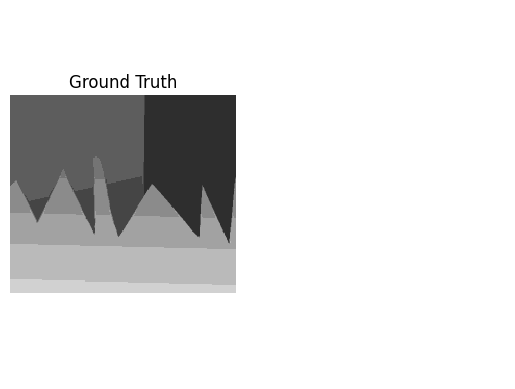

Procesing scanline  0
Procesing scanline  1
Procesing scanline  2
Procesing scanline  3
Procesing scanline  4
Procesing scanline  5
Procesing scanline  6
Procesing scanline  7
Procesing scanline  8
Procesing scanline  9
Procesing scanline  10
Procesing scanline  11
Procesing scanline  12
Procesing scanline  13
Procesing scanline  14
Procesing scanline  15
Procesing scanline  16
Procesing scanline  17
Procesing scanline  18
Procesing scanline  19
Procesing scanline  20
Procesing scanline  21
Procesing scanline  22
Procesing scanline  23
Procesing scanline  24
Procesing scanline  25
Procesing scanline  26
Procesing scanline  27
Procesing scanline  28
Procesing scanline  29
Procesing scanline  30
Procesing scanline  31
Procesing scanline  32
Procesing scanline  33
Procesing scanline  34
Procesing scanline  35
Procesing scanline  36
Procesing scanline  37
Procesing scanline  38
Procesing scanline  39
Procesing scanline  40
Procesing scanline  41
Procesing scanline  42
Procesing scanline  4

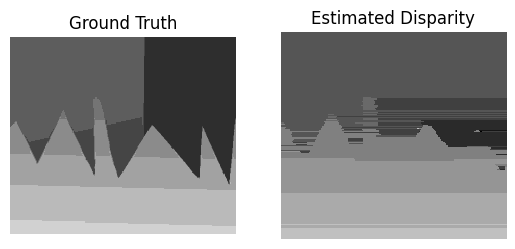

In [14]:
# figure out size of image
imY = len(im1)
imX = len(im1[0])

# define maximum disparity 
maxDisp = 10

# set up pairwiseCosts - we will define a fixed cost of alpha for changing
# disparity or zero cost for staying the same
alpha = 5
pairwiseCosts = alpha*np.ones([maxDisp,maxDisp])-alpha*np.eye(maxDisp)

# initialize the disparity map that we will estimate
estDisp = np.zeros([imY,imX-maxDisp])

# define standard deviation of noise
noiseSD = 20

# display ground truth and estimated disparity
plt.close('all')
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(gtDisp, vmin=0,vmax=11, cmap='gray', extent=[0,len(gtDisp[0]),0,len(gtDisp)],interpolation='nearest')
ax1.axis('off')
ax1.set_title('Ground Truth')
ax2.axis('off')
plt.show()

# run through each line of image
for cY in range(imY):
    print('Procesing scanline ',cY)
    
    # define unary costs - we will not use the last few columns of the
    # image as the disparity might map the pixel outside the valid area of
    # the second image
    unaryCosts = np.zeros([maxDisp,imX-maxDisp])

    for cDisp in range(maxDisp):
        cost = np.zeros(imX - maxDisp)
        for cX in range(imX - maxDisp):
            # Compute the negative log likelihood (Gaussian likelihood)
            offset_pixel_value = im2[cY, cX + cDisp]  # Pixel value in the second image (offset by disparity)
            pixel_value = im1[cY, cX]  # Pixel value in the first image
            cost[cX] = (pixel_value - offset_pixel_value) ** 2 / (2 * noiseSD ** 2)
    
        # Step 2: Store these costs in the unaryCosts matrix.
        unaryCosts[cDisp, :] = cost
    
    # Step 3: Call dynamicProgram function to estimate disparity.
    estDisp[cY, :] = np.transpose(dynamicProgram(unaryCosts, pairwiseCosts))
    
    # Step 4: Investigate the effect of alpha and noiseSD by running experiments with different values.
    # Example: Test different alpha values and plot results.
    alpha_values = [0.5, 1, 2]
    noiseSD_values = [4, 6, 8]
        
        # TODO store this cost in the unaryCosts matrix
        # unaryCosts[ , ] = ...
            
    # TODO uncomment the line below and call the function that you wrote in the previous section (copy it
    # into the cell above)
    
    # estDisp[cY,:] = np.transpose(dynamicProgram(unaryCosts,pairwiseCosts))

    # display solution so far
f, (ax1, ax2) = plt.subplots(1, 2)
#ax1.clear()
ax1.imshow(gtDisp, vmin=0,vmax=11, cmap='gray', extent=[0,len(gtDisp[0]),0,len(gtDisp)],interpolation='nearest')
ax1.axis('off')
ax1.set_title('Ground Truth')
#ax2.clear()
ax2.imshow(estDisp, vmin=0,vmax=12, cmap='gray', extent=[0,len(estDisp[0]),0,len(estDisp)],interpolation='nearest')
ax2.axis('off')
ax2.set_title('Estimated Disparity')
plt.show()
    
    
    
# TODO - investigate how different values of alpha and noiseSD affect the results

# TODO (optional) - rewrite the the "dynamicProgram" in the "dynamicProgramVec" function to make it more efficient. 
# Check the improvements by timining the function calls.

# TODO (optional) - you should be able to rewrite this (calculating unary costs) with fewer loops once you have
#the general idea so that it runs faster. Again you can check the speed improvements by timing them.

# TODO (optional)- adapt the algorithm so that it makes use of colour information

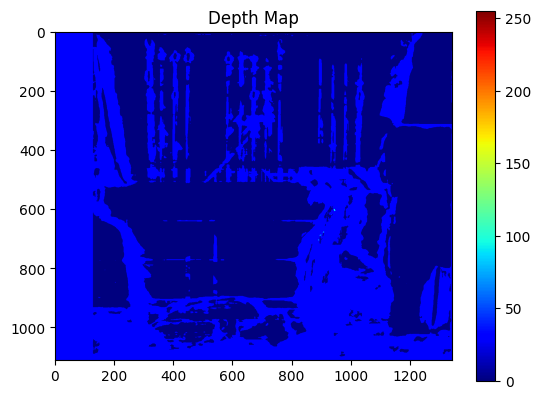

MAE: 64.24457620011242, RMSE: 79.83092227344228


In [88]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load stereo images and ground truth
im1 = cv2.imread('../dataset/view1.png', cv2.IMREAD_GRAYSCALE)
im2 = cv2.imread('../dataset/view5.png', cv2.IMREAD_GRAYSCALE)
gt = cv2.imread('../dataset/disp1.png', cv2.IMREAD_UNCHANGED)
gtDisp = np.round(gt.astype(float) / 16)

# Stereo matcher with SGBM
stereo = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=128,
    blockSize=15,
    P1=8 * 3 * 15**2,
    P2=32 * 3 * 15**2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32
)

# Compute disparity (divide by 16 for scale adjustment)
disparity = stereo.compute(im1, im2).astype(np.float32) / 16.0

# Dataset-specific minimum disparity (dmin = 230)
dmin = 2.30
disparity = disparity - dmin  # Adjust disparity by subtracting the minimum disparity

# Avoid invalid disparities (values less than or equal to 0)
disparity[disparity <= 0] = 0.1  # Set to a small value to avoid divide-by-zero errors

# Camera parameters
focal_length = 3740  # Focal length in pixels (adjust with actual data if necessary)
baseline = 0.16  # Baseline in meters

# Compute depth (Z = f * B / disparity)
depth = (focal_length * baseline) / disparity

# Normalize depth map for visualization
depth_normalized = cv2.normalize(depth, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Display depth map
plt.imshow(depth_normalized, cmap='jet')
plt.colorbar()
plt.title("Depth Map")
plt.show()

# Quantitative evaluation: Compare with ground truth (GT)
mask = gtDisp > 0  # Mask for valid pixels
mae = np.mean(np.abs(disparity[mask] - gtDisp[mask]))  # Mean Absolute Error
rmse = np.sqrt(np.mean((disparity[mask] - gtDisp[mask])**2))  # Root Mean Squared Error
print(f"MAE: {mae}, RMSE: {rmse}")


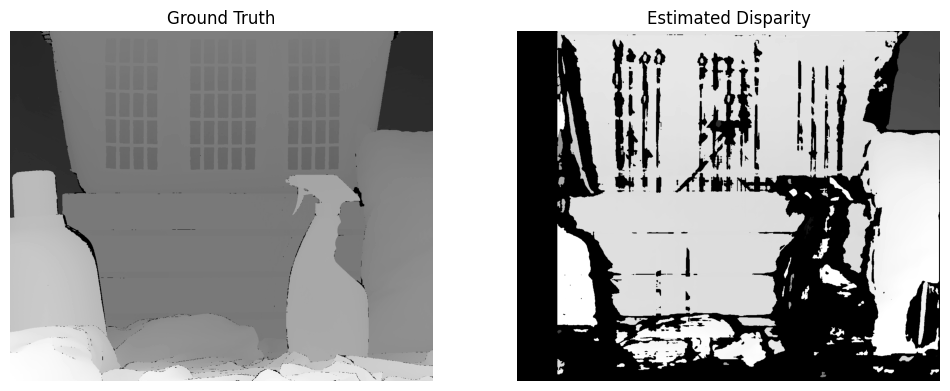

In [101]:
fig, ax = plt.subplots(1,2,figsize=(12,8))
ax[1].imshow(disparity, cmap='grey')
ax[0].imshow(gt, cmap='grey')
ax[0].set_title("Ground Truth")
ax[1].set_title("Estimated Disparity")
ax[0].axis('off')
ax[1].axis('off')
plt.show()